# Branch Prediction Dataset Analysis

This notebook explores the Branch Prediction dataset from Kaggle - a binary classification problem for predicting CPU branch behavior (Taken/Not Taken).

## Dataset Overview
- **Rows**: 400,000 conditional branch records
- **Features**: 482 columns total
  - 32 columns: PC (Program Counter) instruction bits
  - 64 columns: GSHARE table (normalized saturation counters)
  - 384 columns: GA table (48 × 8 binary bits)
  - 1 column: Target (Branch Taken/Not Taken)

## 1. Import Required Libraries

In [ ]:
# %pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Dataset

You can load the dataset in two ways:
1. **Local file**: If you've downloaded the CSV files
2. **Kaggle API**: Download directly using Kaggle API (requires kaggle.json)

In [4]:
# Option 1: Load from local file
# Make sure you have downloaded I04.csv from Kaggle
file_path = 'I04.csv'

try:
    print("Loading dataset... This may take a moment due to the large file size (853 MB)")
    # Try reading with latin-1 encoding to handle non-UTF-8 characters
    df = pd.read_csv(file_path, encoding='latin-1')
    print(f"✓ Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("❌ File not found! Please download I04.csv from Kaggle:")
    print("https://www.kaggle.com/datasets/discdiver/branch-prediction")
    print("\nOr use the Kaggle API in the next cell.")
    df = None
except UnicodeDecodeError as e:
    print(f"❌ Encoding error: {e}")
    print("Trying alternative encoding methods...")
    try:
        df = pd.read_csv(file_path, encoding='cp1252')
        print(f"✓ Dataset loaded successfully with cp1252 encoding!")
        print(f"Shape: {df.shape}")
    except Exception as e2:
        print(f"❌ Failed with alternative encoding: {e2}")
        df = None

Loading dataset... This may take a moment due to the large file size (853 MB)
✓ Dataset loaded successfully!
Shape: (400000, 482)


In [5]:
# Option 2: Download using Kaggle API (uncomment if needed)
# !pip install kaggle
# !kaggle datasets download -d discdiver/branch-prediction
# !unzip branch-prediction.zip

## 3. Basic Dataset Information

In [5]:
if df is not None:
    print("=" * 60)
    print("DATASET INFORMATION")
    print("=" * 60)
    print(f"Number of rows: {df.shape[0]:,}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nColumn names (first 10): {list(df.columns[:10])}")
    print(f"Column names (last 5): {list(df.columns[-5:])}")
    print(f"\nData types:\n{df.dtypes.value_counts()}")

DATASET INFORMATION
Number of rows: 400,000
Number of columns: 482
Memory usage: 1470.95 MB

Column names (first 10): ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8']
Column names (last 5): ['476', '477', '478', '479', '480']

Data types:
float64    481
int64        1
Name: count, dtype: int64


## 4. Examine Dataset Structure

Display first and last rows to understand the data format.

In [6]:
if df is not None:
    print("First 5 rows:")
    print("=" * 60)
    display(df.head())
    
    print("\n" + "=" * 60)
    print("Last 5 rows:")
    print("=" * 60)
    display(df.tail())

First 5 rows:


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,471,472,473,474,475,476,477,478,479,480
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0



Last 5 rows:


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,471,472,473,474,475,476,477,478,479,480
399995,399995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
399996,399996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
399997,399997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
399998,399998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
399999,399999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [8]:
if df is not None:
    print("Full Single Row Display (Row 0):")
    print("=" * 80)
    
    # Display the first row as a Series
    single_row = df.iloc[0]
    
    # Print all columns and their values
    for col_name, value in single_row.items():
        print(f"{col_name}: {value}")
    
    print("\n" + "=" * 80)
    print(f"Total columns: {len(single_row)}")

Full Single Row Display (Row 0):
Unnamed: 0: 0.0
0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 1.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0
15: 1.0
16: 0.0
17: 1.0
18: 1.0
19: 1.0
20: 1.0
21: 1.0
22: 1.0
23: 1.0
24: 0.0
25: 0.0
26: 1.0
27: 1.0
28: 0.0
29: 0.0
30: 1.0
31: 0.0
32: 0.6666666666666666
33: 0.6666666666666666
34: 0.6666666666666666
35: 0.6666666666666666
36: 0.6666666666666666
37: 0.6666666666666666
38: 0.6666666666666666
39: 0.6666666666666666
40: 0.6666666666666666
41: 0.6666666666666666
42: 0.6666666666666666
43: 0.6666666666666666
44: 0.6666666666666666
45: 0.6666666666666666
46: 0.6666666666666666
47: 0.6666666666666666
48: 0.6666666666666666
49: 0.6666666666666666
50: 0.6666666666666666
51: 0.6666666666666666
52: 0.6666666666666666
53: 0.6666666666666666
54: 0.6666666666666666
55: 0.6666666666666666
56: 0.6666666666666666
57: 0.6666666666666666
58: 0.6666666666666666
59: 0.6666666666666666
60: 0.6666666666666666
61: 0.6666666666666666
62: 0.666666666

## 5. Identify Feature Groups

The dataset has 3 main feature groups plus the target:
- **Columns 0-31**: PC instruction (32 binary bits)
- **Columns 32-95**: GSHARE table (64 normalized values)
- **Columns 96-479**: GA table (384 binary bits = 48 × 8)
- **Last column**: Target (Branch Taken/Not Taken)

In [9]:
if df is not None:
    # Identify feature groups
    pc_cols = df.columns[0:32]      # PC instruction bits
    gshare_cols = df.columns[32:96]  # GSHARE table
    ga_cols = df.columns[96:480]     # GA table
    target_col = df.columns[-1]      # Target variable
    
    print("Feature Groups:")
    print("=" * 60)
    print(f"PC Columns (0-31): {len(pc_cols)} columns")
    print(f"  Sample: {list(pc_cols[:5])}")
    print(f"\nGSHARE Columns (32-95): {len(gshare_cols)} columns")
    print(f"  Sample: {list(gshare_cols[:5])}")
    print(f"\nGA Columns (96-479): {len(ga_cols)} columns")
    print(f"  Sample: {list(ga_cols[:5])}")
    print(f"\nTarget Column: {target_col}")

Feature Groups:
PC Columns (0-31): 32 columns
  Sample: ['Unnamed: 0', '0', '1', '2', '3']

GSHARE Columns (32-95): 64 columns
  Sample: ['31', '32', '33', '34', '35']

GA Columns (96-479): 384 columns
  Sample: ['95', '96', '97', '98', '99']

Target Column: 480


## 6. Target Variable Analysis

Examine the distribution of the target variable (Branch Taken vs Not Taken).

In [10]:
if df is not None:
    target = df.iloc[:, -1]
    
    print("Target Variable Statistics:")
    print("=" * 60)
    print(f"Column name: {target.name}")
    print(f"\nValue counts:")
    print(target.value_counts())
    print(f"\nPercentage distribution:")
    print(target.value_counts(normalize=True) * 100)
    
    # Check for class imbalance
    class_ratio = target.value_counts().min() / target.value_counts().max()
    print(f"\nClass balance ratio: {class_ratio:.4f}")
    if class_ratio < 0.8:
        print("⚠️ Dataset shows class imbalance!")
    else:
        print("✓ Dataset is relatively balanced")

Target Variable Statistics:
Column name: 480

Value counts:
480
0.0    335838
1.0     64162
Name: count, dtype: int64

Percentage distribution:
480
0.0    83.9595
1.0    16.0405
Name: proportion, dtype: float64

Class balance ratio: 0.1911
⚠️ Dataset shows class imbalance!


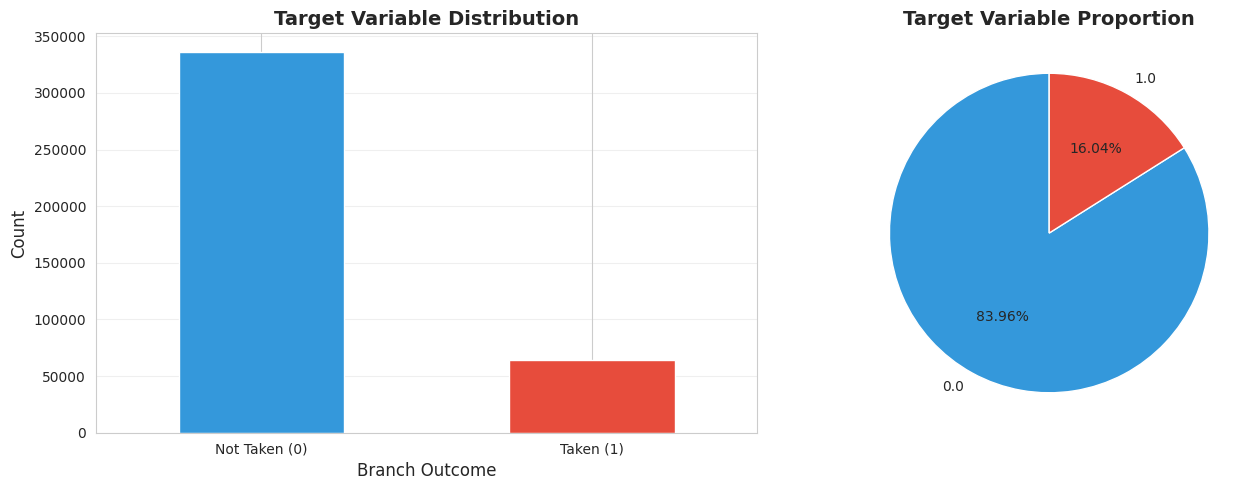

In [10]:
if df is not None:
    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot
    target.value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
    axes[0].set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Branch Outcome', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_xticklabels(['Not Taken (0)', 'Taken (1)'], rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart
    target.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                colors=['#3498db', '#e74c3c'], startangle=90)
    axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

## 7. Feature Statistics by Group

Analyze statistical properties of each feature group.

In [11]:
if df is not None:
    print("PC FEATURES (Columns 0-31) - Binary bits")
    print("=" * 60)
    print(df.iloc[:, 0:32].describe())
    
    print("\n\nGSHARE FEATURES (Columns 32-95) - Normalized values")
    print("=" * 60)
    print(df.iloc[:, 32:96].describe())
    
    print("\n\nGA FEATURES (Columns 96-479) - Binary bits")
    print("=" * 60)
    print(df.iloc[:, 96:480].describe())

PC FEATURES (Columns 0-31) - Binary bits
          Unnamed: 0         0              1              2              3  \
count  400000.000000  400000.0  400000.000000  400000.000000  400000.000000   
mean   199999.500000       0.0       0.000010       0.000010       0.000010   
std    115470.198175       0.0       0.003162       0.003162       0.003162   
min         0.000000       0.0       0.000000       0.000000       0.000000   
25%     99999.750000       0.0       0.000000       0.000000       0.000000   
50%    199999.500000       0.0       0.000000       0.000000       0.000000   
75%    299999.250000       0.0       0.000000       0.000000       0.000000   
max    399999.000000       0.0       1.000000       1.000000       1.000000   

              4              5              6              7              8  \
count  400000.0  400000.000000  400000.000000  400000.000000  400000.000000   
mean        0.0       0.000010       0.000010       0.000010       0.000443   
std       

## 8. Check for Missing Values

In [12]:
if df is not None:
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    print("Missing Values Analysis:")
    print("=" * 60)
    print(f"Total missing values: {missing_values.sum()}")
    print(f"Columns with missing values: {(missing_values > 0).sum()}")
    
    if missing_values.sum() == 0:
        print("\n✓ No missing values found! Dataset is complete.")
    else:
        print("\n⚠️ Columns with missing values:")
        missing_df = pd.DataFrame({
            'Column': missing_values[missing_values > 0].index,
            'Missing_Count': missing_values[missing_values > 0].values,
            'Percentage': missing_percent[missing_values > 0].values
        })
        display(missing_df)

Missing Values Analysis:
Total missing values: 0
Columns with missing values: 0

✓ No missing values found! Dataset is complete.


## 9. GSHARE Features Distribution

Visualize the distribution of GSHARE features (normalized saturation counters).

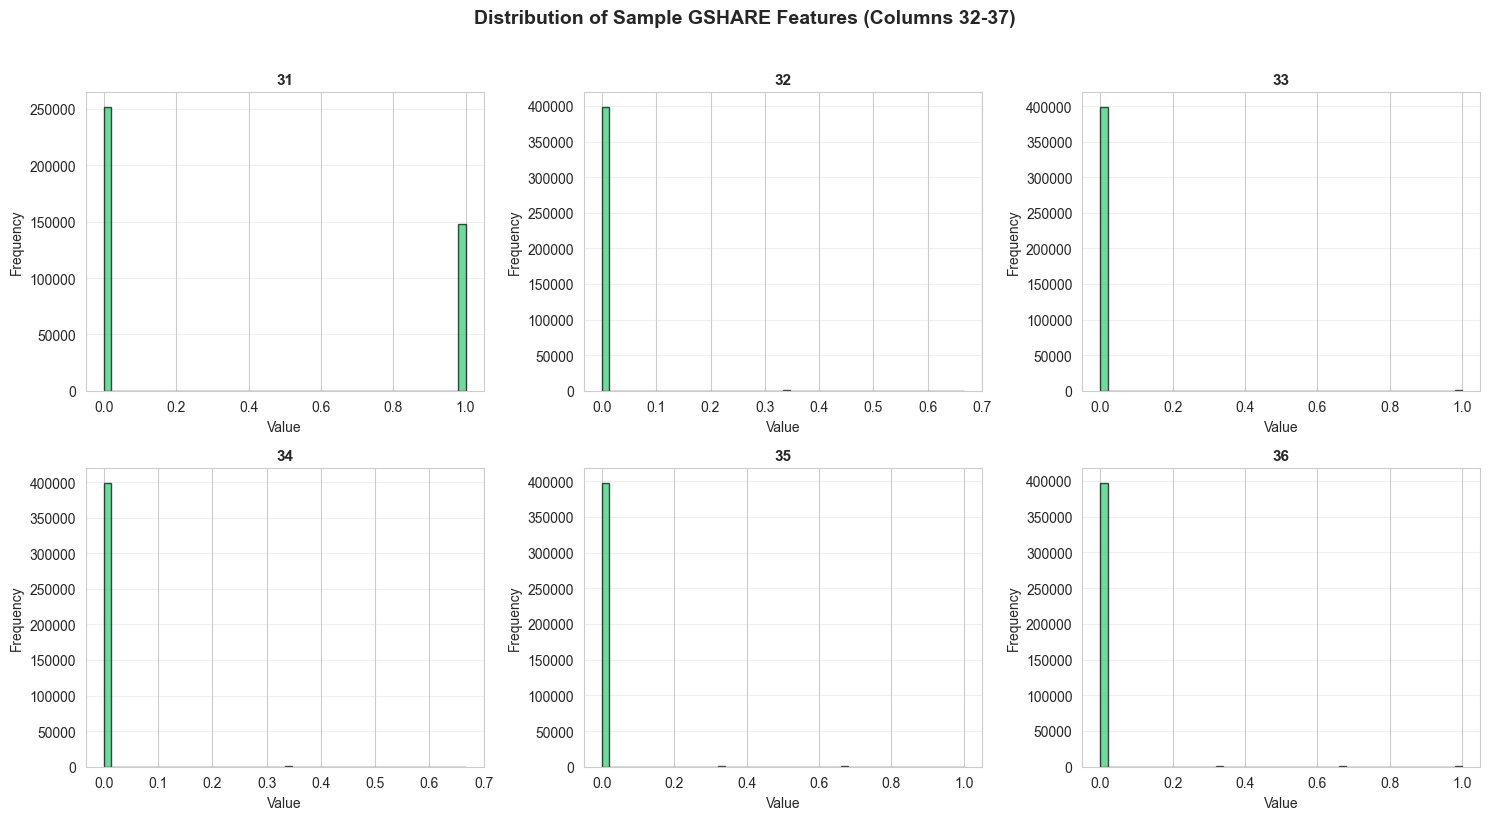

In [13]:
if df is not None:
    # Sample GSHARE columns for visualization
    gshare_sample = df.iloc[:, 32:38]  # First 6 GSHARE columns
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(gshare_sample.columns):
        axes[idx].hist(df[col], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Distribution of Sample GSHARE Features (Columns 32-37)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 10. Correlation Analysis

Analyze correlations between features and the target variable.

In [14]:
if df is not None:
    # Calculate correlation with target for each feature group
    target = df.iloc[:, -1]
    
    # PC features correlation
    pc_corr = df.iloc[:, 0:32].corrwith(target).abs().sort_values(ascending=False)
    
    # GSHARE features correlation
    gshare_corr = df.iloc[:, 32:96].corrwith(target).abs().sort_values(ascending=False)
    
    # GA features correlation (sample)
    ga_corr = df.iloc[:, 96:480].corrwith(target).abs().sort_values(ascending=False)
    
    print("Top 10 Correlated Features with Target:")
    print("=" * 60)
    print("\nPC Features:")
    print(pc_corr.head(10))
    print("\nGSHARE Features:")
    print(gshare_corr.head(10))
    print("\nGA Features (top 10):")
    print(ga_corr.head(10))

Top 10 Correlated Features with Target:

PC Features:
27    0.412192
28    0.355190
18    0.205834
29    0.081766
16    0.063005
12    0.057721
13    0.054302
24    0.043607
19    0.036780
26    0.034544
dtype: float64

GSHARE Features:
31    0.117733
39    0.053318
43    0.052290
69    0.052215
86    0.049962
67    0.045487
66    0.045342
47    0.044155
36    0.043160
44    0.040077
dtype: float64

GA Features (top 10):
437    0.522205
375    0.490766
471    0.466443
454    0.435024
279    0.426188
341    0.417475
433    0.415964
438    0.413572
475    0.412192
398    0.410043
dtype: float64


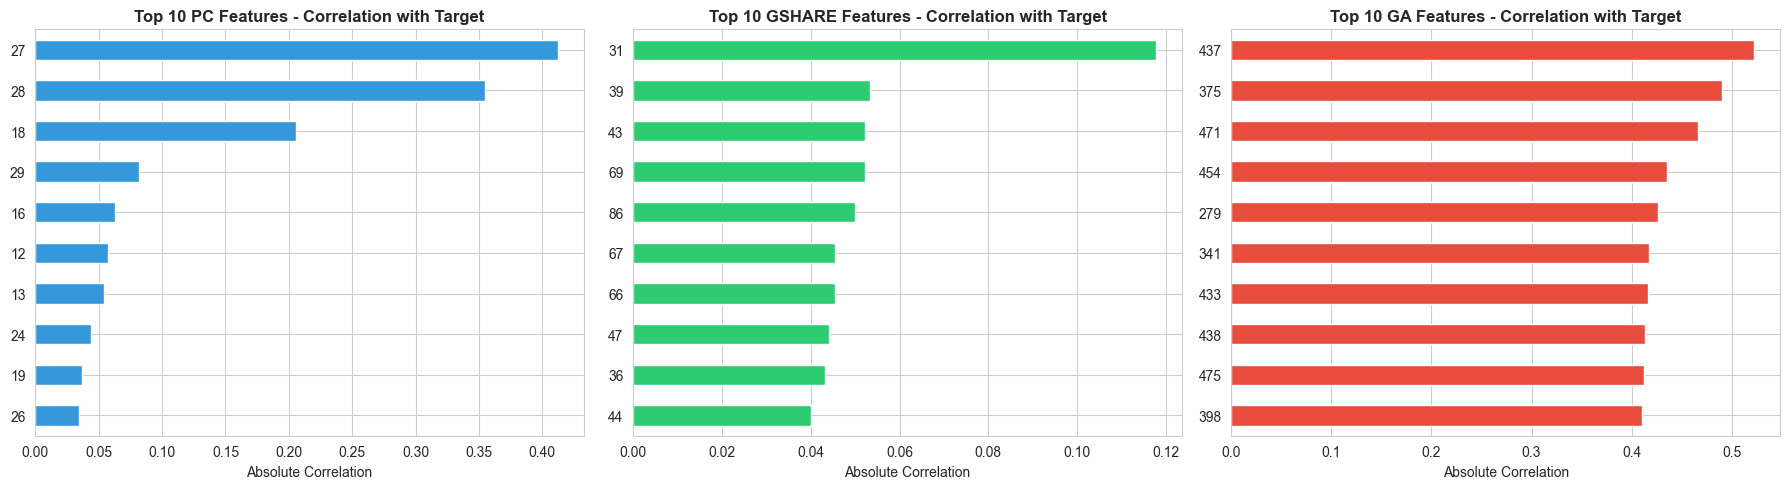

In [15]:
if df is not None:
    # Visualize top correlated features from each group
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PC features
    pc_corr.head(10).plot(kind='barh', ax=axes[0], color='#3498db')
    axes[0].set_title('Top 10 PC Features - Correlation with Target', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Absolute Correlation', fontsize=10)
    axes[0].invert_yaxis()
    
    # GSHARE features
    gshare_corr.head(10).plot(kind='barh', ax=axes[1], color='#2ecc71')
    axes[1].set_title('Top 10 GSHARE Features - Correlation with Target', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Absolute Correlation', fontsize=10)
    axes[1].invert_yaxis()
    
    # GA features
    ga_corr.head(10).plot(kind='barh', ax=axes[2], color='#e74c3c')
    axes[2].set_title('Top 10 GA Features - Correlation with Target', 
                      fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Absolute Correlation', fontsize=10)
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

## 11. Correlation Heatmap (Sample Features)

Visualize correlations between sample GSHARE features.

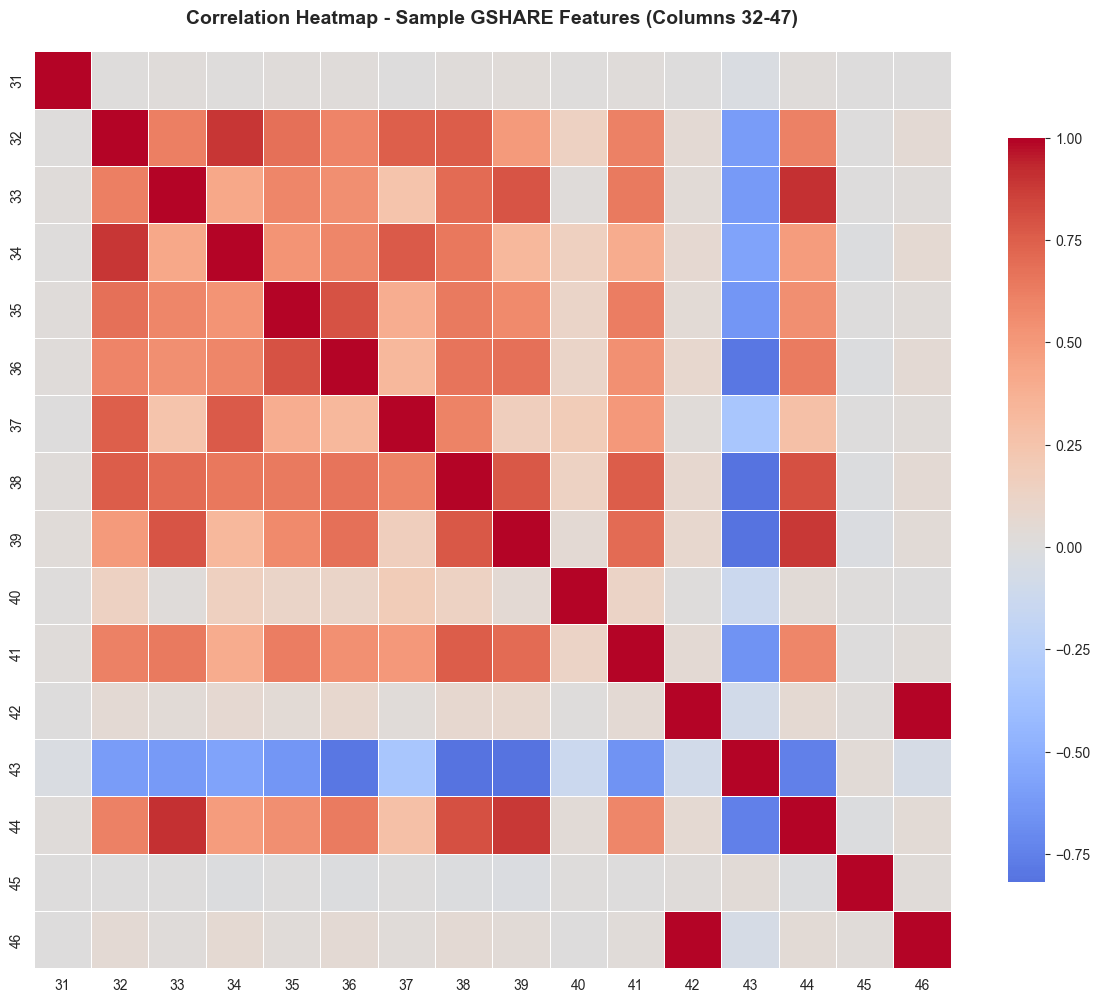

In [16]:
if df is not None:
    # Sample GSHARE features for heatmap (to avoid overplotting)
    gshare_sample = df.iloc[:, 32:48]  # First 16 GSHARE columns
    correlation_matrix = gshare_sample.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap - Sample GSHARE Features (Columns 32-47)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

## 12. Feature Value Distribution by Target

Compare feature distributions between Taken and Not Taken branches.

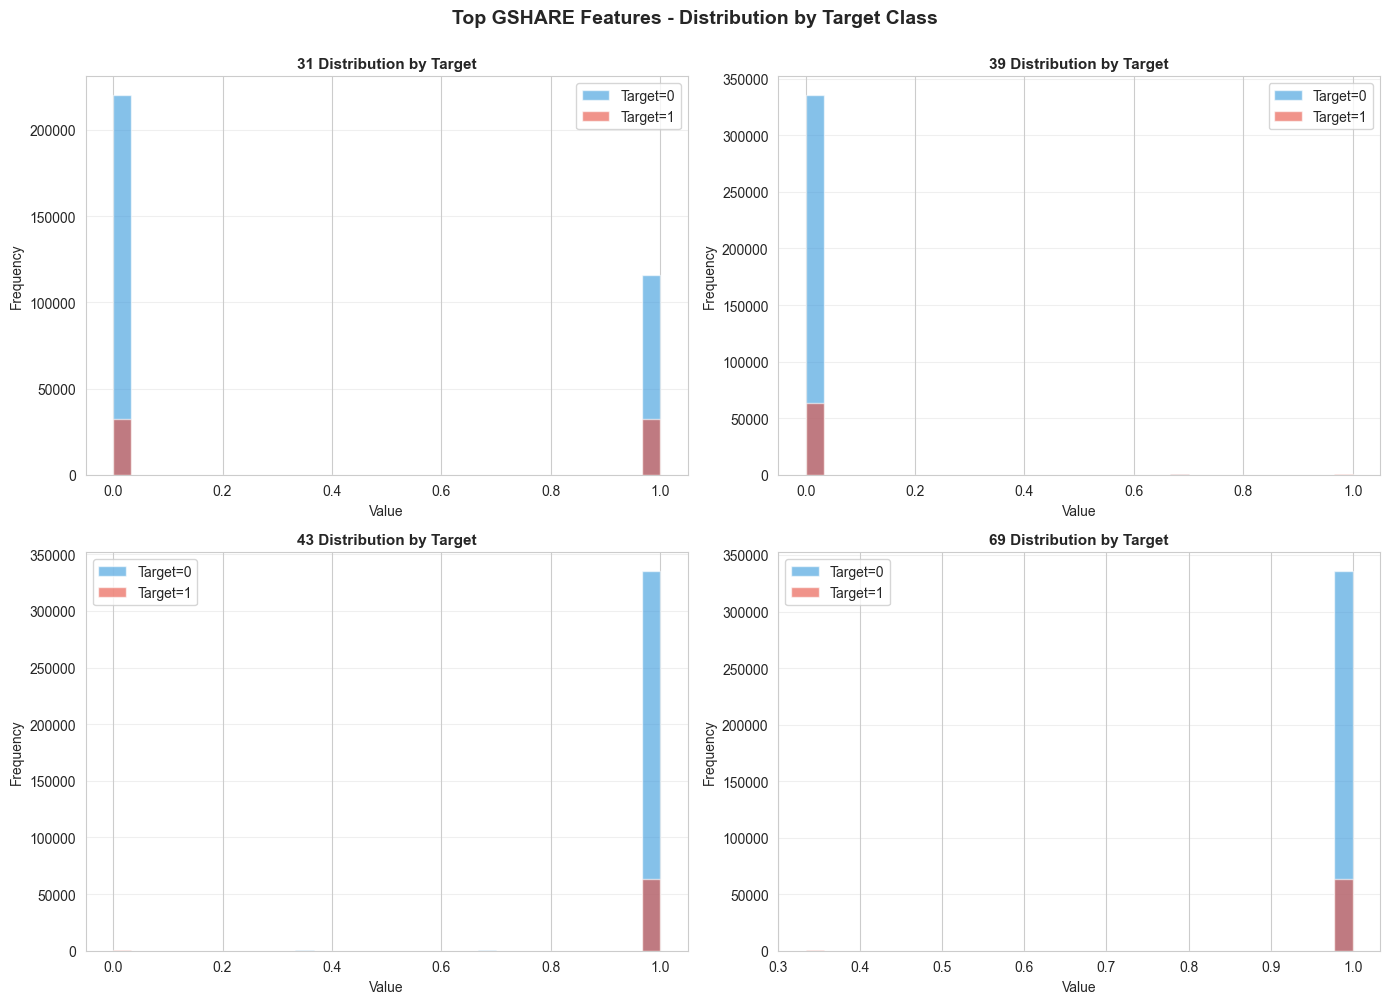

In [17]:
if df is not None:
    # Select top correlated GSHARE features
    target = df.iloc[:, -1]
    top_gshare_features = gshare_corr.head(4).index
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_gshare_features):
        for target_val in [0, 1]:
            data = df[df.iloc[:, -1] == target_val][feature]
            axes[idx].hist(data, bins=30, alpha=0.6, 
                          label=f'Target={target_val}', 
                          color='#3498db' if target_val == 0 else '#e74c3c')
        
        axes[idx].set_title(f'{feature} Distribution by Target', 
                           fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Top GSHARE Features - Distribution by Target Class', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

## 13. Summary Statistics

Key insights from the dataset exploration.

In [18]:
if df is not None:
    print("=" * 70)
    print(" " * 20 + "DATASET SUMMARY")
    print("=" * 70)
    
    print(f"\n📊 Dataset Size:")
    print(f"   • Total Rows: {df.shape[0]:,}")
    print(f"   • Total Columns: {df.shape[1]}")
    print(f"   • Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n🎯 Target Distribution:")
    target_counts = df.iloc[:, -1].value_counts()
    for val, count in target_counts.items():
        pct = (count / len(df)) * 100
        print(f"   • Class {val}: {count:,} ({pct:.2f}%)")
    
    print(f"\n📈 Feature Groups:")
    print(f"   • PC Features (Binary): 32 columns (0-31)")
    print(f"   • GSHARE Features (Normalized): 64 columns (32-95)")
    print(f"   • GA Features (Binary): 384 columns (96-479)")
    print(f"   • Target Column: 1 column")
    
    print(f"\n✓ Data Quality:")
    print(f"   • Missing Values: {df.isnull().sum().sum()}")
    print(f"   • Duplicate Rows: {df.duplicated().sum()}")
    
    print(f"\n🔍 Top Predictive Features:")
    all_corr = df.iloc[:, :-1].corrwith(df.iloc[:, -1]).abs().sort_values(ascending=False)
    print(f"   Top 5 Most Correlated with Target:")
    for idx, (feat, corr) in enumerate(all_corr.head(5).items(), 1):
        print(f"   {idx}. {feat}: {corr:.4f}")
    
    print("\n" + "=" * 70)

                    DATASET SUMMARY

📊 Dataset Size:
   • Total Rows: 400,000
   • Total Columns: 482
   • Memory Usage: 1470.95 MB

🎯 Target Distribution:
   • Class 0.0: 335,838 (83.96%)
   • Class 1.0: 64,162 (16.04%)

📈 Feature Groups:
   • PC Features (Binary): 32 columns (0-31)
   • GSHARE Features (Normalized): 64 columns (32-95)
   • GA Features (Binary): 384 columns (96-479)
   • Target Column: 1 column

✓ Data Quality:
   • Missing Values: 0
   • Duplicate Rows: 0

🔍 Top Predictive Features:
   Top 5 Most Correlated with Target:
   1. 437: 0.5222
   2. 375: 0.4908
   3. 471: 0.4664
   4. 454: 0.4350
   5. 279: 0.4262



## Next Steps

Now that you've explored the dataset, you can:

1. **Build a Classification Model**: Use algorithms like Random Forest, XGBoost, or Neural Networks
2. **Feature Engineering**: Create new features from PC, GSHARE, and GA combinations
3. **Handle Class Imbalance**: Apply SMOTE or class weighting if needed
4. **Cross-Validation**: Evaluate model performance with k-fold CV
5. **Hyperparameter Tuning**: Optimize model parameters for better accuracy

Happy modeling! 🚀